<h1><center> Playing Atari using Evolution Strategies </center></h1>


## 1. Import Dependencies


In [0]:
from google.colab import drive
user_name = '/content/drive'
drive.mount(user_name, force_remount=True)
# !lscpu
from __future__ import absolute_import, division, print_function
# !pip install torch
!pip install gym
!pip install gym[atari]
import math, random
import time
import argparse
import copy
from multiprocessing import Pool
# from multiprocessing.pool import ThreadPool
from functools import partial
import gym
import numpy as np
import pickle as pkl
from matplotlib.image import imsave
import torch
import torch.nn as nn
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F
from collections import deque
import matplotlib.pyplot as plt

checkpoint_name = '/content/drive/My Drive/Colab Notebooks/Checkpoint/'

USE_CUDA = False
device = torch.device('cuda' if USE_CUDA else 'cpu')
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 2. Evolution Strategies

In [0]:
def get_reward(weights, model, render=False):
    cloned_model = copy.deepcopy(model)
    for i, param in enumerate(cloned_model.parameters()):
        try:
            param.data.copy_(weights[i])
        except:
            param.data.copy_(weights[i].data)

    ob, env = process_atari(env_id)
    done = False
    total_reward = 0
    while not done:
        batch = torch.FloatTensor(ob[np.newaxis,...]).to(device)
        prediction = cloned_model(Variable(batch))
        action = prediction.cpu().data.numpy().argmax()
        new_ob, reward, done, _ = env.step(action)
        new_ob = env.unwrapped._get_ram()
        ob = new_ob

        total_reward += reward 

    env.close()
    return total_reward

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        m.weight.data.normal_(0.0, 0.02)

class EvolutionModule:

    def __init__(
        self, 
        weights, 
        reward_func,
        population_size=50,
        sigma=0.1,
        learning_rate=0.001,
        decay=1.0,
        sigma_decay=1.0,
        threadcount=4,
        render_test=False,
        cuda=False,
        reward_goal=None,
        consecutive_goal_stopping=None,
        save_path=None
    ):
        np.random.seed(int(time.time()))
        self.weights = weights
        self.reward_function = reward_func
        self.POPULATION_SIZE = population_size
        self.SIGMA = sigma
        self.LEARNING_RATE = learning_rate
        self.cuda = cuda
        self.decay = decay
        self.sigma_decay = sigma_decay
        self.pool = Pool(threadcount) #Thread
        self.render_test = render_test
        self.reward_goal = reward_goal
        self.consecutive_goal_stopping = consecutive_goal_stopping
        self.consecutive_goal_count = 0
        self.save_path = save_path
        self.max_rewards = []
        self.min_rewards = []
        self.avg_rewards = []


    def jitter_weights(self, weights, population=[], no_jitter=False):
        new_weights = []
        for i, param in enumerate(weights):
            if no_jitter:
                new_weights.append(param.to(device).detach()) #.data
            else:
                jittered = torch.FloatTensor(self.SIGMA * population[i]).detach()
                jittered = jittered.to(device).detach()
                new_weights.append(param.to(device).detach() + jittered) #.data
        return new_weights


    def run(self, iterations, print_step=100):
        for iteration in range(iterations):
            torch.cuda.empty_cache()
            population = []
            for _ in range(self.POPULATION_SIZE):
                x = []
                for param in self.weights:
                    x.append(np.random.randn(*param.data.size()))
                population.append(x)

            rewards = self.pool.map(
                self.reward_function, 
                [self.jitter_weights(copy.deepcopy(self.weights), population=pop) for pop in population]
            )
            self.max_rewards.append(max(rewards))
            self.min_rewards.append(min(rewards))
            self.avg_rewards.append(np.mean(rewards))
            if np.std(rewards) != 0:
                normalized_rewards = (rewards - np.mean(rewards)) / np.std(rewards)
                for index, param in enumerate(self.weights):
                    A = np.array([p[index] for p in population])
                    rewards_pop = torch.FloatTensor(np.dot(A.T, normalized_rewards).T).to(device)
                    param = param.to(device)
                    param = param + self.LEARNING_RATE / (self.POPULATION_SIZE * self.SIGMA) * rewards_pop

                    self.LEARNING_RATE *= self.decay
                    self.SIGMA *= self.sigma_decay

            test_reward = self.reward_function(
                self.jitter_weights(copy.deepcopy(self.weights), no_jitter=True), render=self.render_test
            )
            if (iteration+1) % print_step == 0:
                print('iter %d. reward: %f' % (iteration+1, test_reward))
                if self.save_path:
                    pickle.dump(self.weights, open(self.save_path+'weights.pkl', 'wb'))
                
                if self.reward_goal and self.consecutive_goal_stopping:
                    if test_reward >= self.reward_goal:
                        self.consecutive_goal_count += 1
                    else:
                        self.consecutive_goal_count = 0

                    if self.consecutive_goal_count >= self.consecutive_goal_stopping:
                        return self.weights
        return self.weights, self.max_rewards,self.min_rewards,self.avg_rewards

## 3. ConvNet Model

In [0]:
class CnnDQN(nn.Module):
    def __init__(self, input_shape, num_actions):
        super(CnnDQN, self).__init__()
        
        self.input_shape = input_shape
        self.num_actions = num_actions
        
        self.features = nn.Sequential(
            nn.Conv2d(input_shape[0], 32, kernel_size=8, stride=4),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1),
            nn.ReLU()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(self.feature_size(), 512),
            nn.ReLU(),
            nn.Linear(512, self.num_actions)
        )
        
    def forward(self, x):
        x   = Variable(torch.FloatTensor(x).unsqueeze(0), volatile=True)
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x
    
    def feature_size(self):
        return self.features(autograd.Variable(torch.zeros(1, *self.input_shape))).view(1, -1).size(1)
    

## 4. Initialize Learning


In [0]:
def process_atari(env_id, atari=False):
    if atari:
      env    = make_atari(env_id)
      env    = wrap_deepmind(env)
      env    = wrap_pytorch(env)
      state = env.reset()
      action = 1
      next_state, reward, done, _ = env.step(action)
      for _ in range(3):
          state = np.concatenate((state,next_state),0)
    else:
      env = gym.make(env_id)
      state = env.reset()
      state = env.unwrapped._get_ram()
    return state, env


sigma = 1
es_learning_rate = 0.0001
es_decay = 0.9999
threads = 2
goal = 300
stop = 10
es_steps = 1000

hyper_epochs = 50
pop_size = 2
batch_size = 32
gamma      = 0.99
epsilon = 0.10
replay_initial = 32
wta_steps = 5000
losses = []
rewards = []

env_id = "Breakout-v0"
state, env = process_atari(env_id)

# model = CnnDQN((4,84,84), env.action_space.n).to(device)

# os.sched_setaffinity(os.getpid(), {0})
# os.system("taskset -p 0xffffffff %d" % os.getpid())
model = nn.Sequential(
    nn.Linear(128, 32),
    nn.Tanh(),
    nn.Linear(32,16),
    nn.Tanh(),
    nn.Linear(16,8),
    nn.Tanh(),
    nn.Linear(8, env.action_space.n),
).to(device)    

# os.sched_setaffinity(os.getpid(), {0})

# print(os.sched_getaffinity(os.getpid()))


## 5. Learning Loop

In [0]:
partial_func = partial(get_reward, model=model)
mother_parameters = list(model.parameters())

start_time = time.time()

es = EvolutionModule(
    mother_parameters, partial_func, population_size=pop_size, sigma=sigma, 
    learning_rate=es_learning_rate, decay = es_decay, threadcount=threads, cuda=True, reward_goal=goal,
    consecutive_goal_stopping=stop)
final_weights,max_rewards,min_rewards,avg_rewards = es.run(es_steps, print_step=10)

end_time = time.time()

data_save = {}
data_save['time'] = [start_time,end_time]
data_save['max_rewards'] = max_rewards
data_save['min_reward'] = min_rewards
data_save['avg_reward'] = avg_rewards

with open(checkpoint_name+'data.pkl', 'wb') as f:
    pkl.dump(data_save, f)

with open(checkpoint_name+'weights.pkl', 'wb') as f:
    pkl.dump(final_weights, f)

iter 10. reward: 0.000000
iter 20. reward: 0.000000
iter 30. reward: 0.000000
iter 40. reward: 0.000000
iter 50. reward: 0.000000
iter 60. reward: 0.000000
iter 70. reward: 0.000000
iter 80. reward: 0.000000
iter 90. reward: 0.000000
iter 100. reward: 0.000000
iter 110. reward: 0.000000
iter 120. reward: 0.000000
iter 130. reward: 0.000000
iter 140. reward: 0.000000
iter 150. reward: 0.000000
iter 160. reward: 0.000000
iter 170. reward: 0.000000
iter 180. reward: 0.000000
iter 190. reward: 0.000000
iter 200. reward: 0.000000
iter 210. reward: 0.000000
iter 220. reward: 0.000000
iter 230. reward: 0.000000
iter 240. reward: 0.000000
iter 250. reward: 0.000000
iter 260. reward: 0.000000
iter 270. reward: 0.000000
iter 280. reward: 0.000000
iter 290. reward: 0.000000
iter 300. reward: 0.000000
iter 310. reward: 0.000000
iter 320. reward: 0.000000
iter 330. reward: 0.000000


Process ForkPoolWorker-24:
Process ForkPoolWorker-23:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/pool.py", line 108, in worker
    task = get()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 335, in get
    res = self._reader.recv_bytes()
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/usr/lib/python3.6/multiprocessing/synchronize.py", line 95,

KeyboardInterrupt: ignored

## 6. Visualization

-165.17953300476074


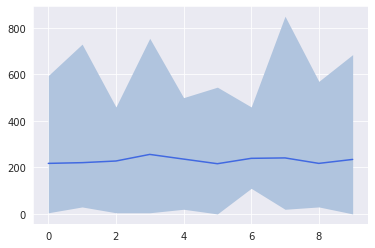

In [0]:
import seaborn as sns

sns.set_style('darkgrid')
plt.plot(avg_rewards,color='royalblue')
plt.fill_between(np.arange(0,len(avg_rewards),1),min_rewards,max_rewards,facecolor='lightsteelblue',linewidth=0)

print(end_time - start_time)

## 5. References

[Karpathy's Blog](https://gist.github.com/karpathy/77fbb6a8dac5395f1b73e7a89300318d)

[Evolution directed towards Exploration](https://papers.nips.cc/paper/7750-improving-exploration-in-evolution-strategies-for-deep-reinforcement-learning-via-a-population-of-novelty-seeking-agents.pdf)

[A more readable version of the code in PyTorch](https://github.com/staturecrane/PyTorch-ES)

[Dreamer (This paper came out a couple of days back and makes use of images to imagine 'k' states)](https://arxiv.org/pdf/1912.01603.pdf)